# Fluctuation Analyses

This notebook covers 'fluctuation' analyses, which examine patterns of fluctuations in time series.

This notebook covers:
- The Hurst Exponent
- Detrended Fluctuation analyses

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined
from neurodsp.aperiodic import compute_fluctuations
from neurodsp.utils import set_random_seed
from neurodsp.aperiodic.conversions import convert_exponent_alpha, convert_alpha_exponent

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_sims
from apm.methods import hurst, dfa
from apm.methods.settings import HURST_PARAMS, DFA_PARAMS
from apm.plts.sims import plot_ap_sims, plot_pe_sims
from apm.sim.settings import FS, SIM_PARAMS_AP, SIM_PARAMS_COMB, EXPS, FREQS, POWERS, N_SIMS, EXP
from apm.sim.examples import SIG_AP, SIG_KN, SIG_OSC, SIG_COMB

/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/methods/fit.py:16: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Set the random seed
set_random_seed(111)

In [5]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '14_fluctuations'

## Hurst Exponent

The Hurst exponent is a method for measuring the self-similarity of a signal.

In [6]:
# Check Hurst exponent settings
HURST_PARAMS

{'fs': 1000, 'n_scales': 10, 'min_scale': 0.1, 'max_scale': 2.0}

### Hurst Exponent on Example Signals

Compute the Hurst exponent on some example signals.

In [7]:
# Check the calculated hurst exponent, and the expected value
print('Computed Hurst signals:')
print('  powerlaw: \t {:1.4f} \t {:1.2f}'.format(hurst(SIG_AP, **HURST_PARAMS), 0.5))
print('  osc:      \t {:6.4f}'.format(hurst(SIG_OSC, **HURST_PARAMS)))
print('  combined: \t {:1.4f}'.format(hurst(SIG_COMB, **HURST_PARAMS)))
print('  knee:     \t {:1.4f}'.format(hurst(SIG_KN, **HURST_PARAMS)))

Computed Hurst signals:
  powerlaw: 	 0.5801 	 0.50
  osc:      	 -0.0033
  combined: 	 0.4909
  knee:     	 0.5818


### Hurst Exponent: Aperiodic Variations

In [8]:
# Run a set of simulations, calculating Hurst across exponents
hurst_sims_exp, hurst_sims_exp_var = run_sims(\
    sim_powerlaw, SIM_PARAMS_AP, hurst, HURST_PARAMS,
    'update_exp', EXPS, N_SIMS, var_func=np.std)

In [9]:
# Run a set of simulations, calculating Hurst across exponents, with an oscillation
hurst_sims_comb, hurst_sims_comb_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, hurst, HURST_PARAMS,
    'update_comb_exp', EXPS, N_SIMS, var_func=np.std)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


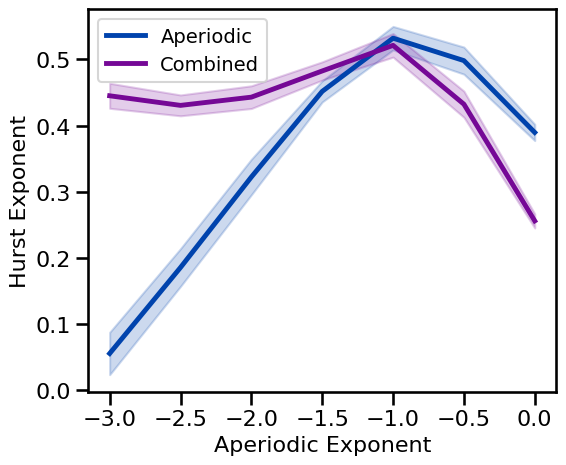

In [10]:
# Plot Hurst exponent estimates across aperiodic variations
plot_ap_sims(hurst_sims_exp, hurst_sims_exp_var, hurst_sims_comb, hurst_sims_comb_var,
             'Hurst Exponent', save_fig=SAVE_FIG, file_name='hurst_ap' + EXT, file_path=FIGPATH)

### Hurst Exponent: Periodic Variations

In [11]:
# Run a set of simulations, calculating Hurst Exponent across oscillation frequencies
hurst_sims_freq, hurst_sims_freq_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, hurst, HURST_PARAMS,
    'update_freq', FREQS, N_SIMS, var_func=np.std)

In [12]:
# Run a set of simulations, calculating Hurst across oscillation power
hurst_sims_pow, hurst_sims_pow_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, hurst, HURST_PARAMS,
    'update_pow', POWERS, N_SIMS, var_func=np.std)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


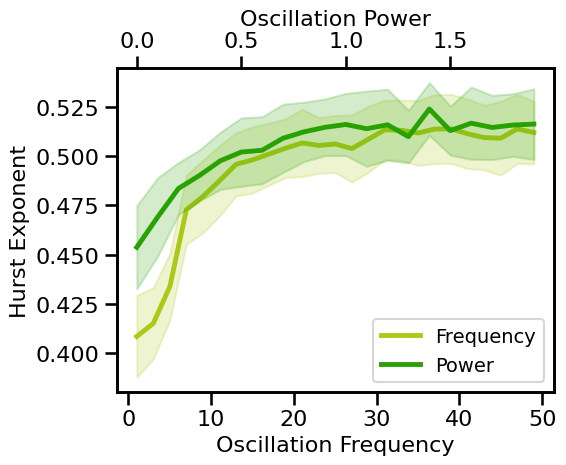

In [13]:
# Plot Hurst exponent estimates across periodic variations
plot_pe_sims(hurst_sims_freq, hurst_sims_freq_var, hurst_sims_pow, hurst_sims_pow_var,
             'Hurst Exponent', save_fig=SAVE_FIG, file_name='hurst_pe' + EXT, file_path=FIGPATH)

## Detrended Fluctuation Analysis

Detrended Fluctuation Analysis is a method for measuring the self-similarity of a signal, and can be applied to measure properties of 1/f-distributed signals.

DFA measures an output value, $\alpha$ which can be interpreted as:
- $\alpha$ < 0.5   anti-correlated signal
- $\alpha$ ~= 0.5: uncorrelated / white noise
- $\alpha$ > 0.5: correlated
    - For example: pink noise ($1/f^1$) ~= 1 & brown noise ($1/f^2$) ~= 1.5

The DFA measure $\alpha$, _should_ relate to the power spectrum exponent $f^\chi$ as:
- $\chi$ = 2$\alpha$ - 1 or
- $\alpha$ = ($\chi$ + 1) / 2

In this notebook, we will explore:
- applying DFA to neural time signals
- how DFA measures relate to different properties of neural time series
- compare DFA measures to other measures of 1/f. 

### Notes
- It looks like the expected relationship between DFA & 1/f appears to be true in the range of $\chi$ from -3 to 0. 
    - It seems like it breaks down with exponent of less than -3
    - It also doesn't seem to hold for exponents > 0
- The presence of an oscillations decreases measures DFA
    - Increasing the frequency of the oscillation further decreases measured DFA
    - Increasing the relative power of the oscillation further decreases measured DFA
- It would appear that given a combined signal, the measured DFA is upper-bound at the expected DFA given the exponent

### Settings

In [14]:
# Check DFA settings
DFA_PARAMS

{'fs': 1000, 'n_scales': 10, 'min_scale': 0.1, 'max_scale': 2.0, 'deg': 1}

### DFA on Example Signals

In [15]:
# Check the computed DFA exponents on some example signals
print('DFA exponents:')
print('  powerlaw: \t {:1.4f} \t {:1.2f}'.format(dfa(SIG_AP, **DFA_PARAMS),
                                                 convert_exponent_alpha(EXP)))
print('  osc:      \t {:1.4f}'.format(dfa(SIG_OSC, **DFA_PARAMS)))
print('  combined: \t {:1.4f}'.format(dfa(SIG_COMB, **DFA_PARAMS)))
print('  knee:     \t {:1.4f}'.format(dfa(SIG_KN, **DFA_PARAMS)))

DFA exponents:
  powerlaw: 	 1.3899 	 1.25
  osc:      	 0.0078
  combined: 	 0.9427
  knee:     	 0.6391


### DFA Simulations: Aperiodic Variations

In [16]:
# Calculate the expected DFA exponent value for each powerlaw exponent
expected = [convert_exponent_alpha(exp) for exp in EXPS]

In [17]:
# Run a set of simulations, calculating DFA across exponents
dfa_sims_exp, dfa_sims_exp_var = run_sims(\
    sim_powerlaw, SIM_PARAMS_AP, dfa, DFA_PARAMS,
    'update_exp', EXPS, N_SIMS, var_func=np.std)

In [18]:
# Run a set of simulations, calculating DFA across exponents, with an oscillation
dfa_sims_comb, dfa_sims_comb_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, dfa, DFA_PARAMS,
    'update_comb_exp', EXPS, N_SIMS, var_func=np.std)

#### Plot Aperiodic & Combined Together

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


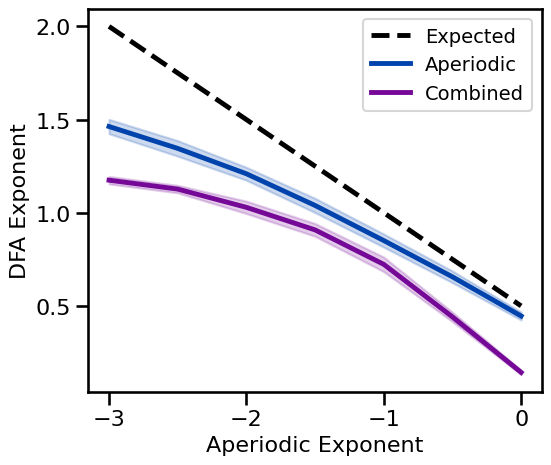

In [19]:
# Plot DFA measures across exponents
plot_ap_sims(dfa_sims_exp, dfa_sims_exp_var, dfa_sims_comb, dfa_sims_comb_var,
             'DFA Exponent', expected=expected,
             save_fig=SAVE_FIG, file_name='dfa_ap' + EXT, file_path=FIGPATH)

### DFA Simulations: Periodic Variations

In [20]:
# Run a set of simulations, calculating DFA across oscillation frequencies
dfa_sims_freq, dfa_sims_freq_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, dfa, DFA_PARAMS,
    'update_freq', FREQS, N_SIMS, var_func=np.std)

In [21]:
# Run a set of simulations, calculating DFA across oscillation power
dfa_sims_pow, dfa_sims_pow_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, dfa, DFA_PARAMS,
    'update_pow', POWERS, N_SIMS, var_func=np.std)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


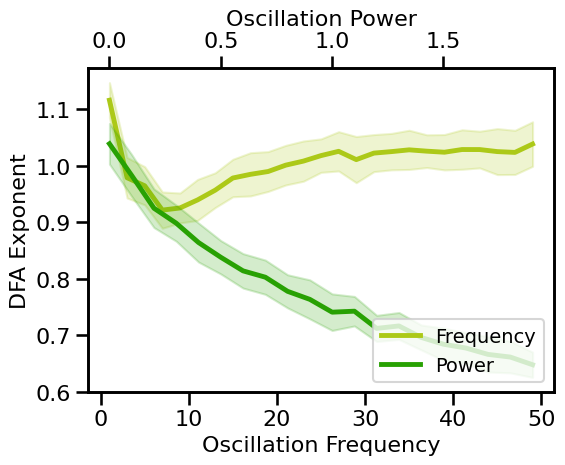

In [22]:
# Plot effect of oscillation variation on DFA exponent
plot_pe_sims(dfa_sims_freq, dfa_sims_freq_var, dfa_sims_pow, dfa_sims_pow_var,
             'DFA Exponent', save_fig=SAVE_FIG, file_name='dfa_pe' + EXT, file_path=FIGPATH)

## Conclusions

Overall, we can see the following patterns in these simulations:

Hurst Exponent:
- has a parabolic relationship with aperiodic exponent, maximal at an exponent of -1
- is less affected by oscillation, increasing slightly with increasing frequency or power

Detrended Fluctuation Analysis:
- decreases with decreasing aperiodic exponent 
- when an oscillation is present, the expected DFA value (for the 1/f) is under-estimated
- has a complex relationship with oscillation frequency, decreases with increasing oscillation power